## 0. Packages intallation

In [ ]:
!pip install langdetect
!pip install transformers
!pip install sentence-transformers
!pip install ktrain
!pip install scikit-plot

In [ ]:
# Connection with Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Definition of the project base folder
dir_base = "/content/drive/My Drive/Sorcero_Test"
dir_dataset = dir_base + "/data/"

In [ ]:
# Importing useful libraries
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline
%time
import time
import random
import pandas as pd
import numpy as np
import os
import re
import shutil
import sys
import string
import regex
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from langdetect import detect, DetectorFactory
from transformers import TFBertModel, create_optimizer, BertTokenizer, BertModel
from nltk.tokenize import RegexpTokenizer
from ktrain import text
import scikitplot as skplt
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


## 1. Exploring the dataset

In [ ]:
# Importing dataset

df_dev = pd.read_csv(dir_dataset + "/dev.tsv",sep= "\t", index_col=0)
df_train = pd.read_csv(dir_dataset + "/train.tsv",sep= "\t", index_col=0)
df_test = pd.read_csv(dir_dataset + "/test.tsv", sep= "\t", index_col=0)

df_dataset = pd.concat([df_dev, df_train, df_test]) # Concatenating datasets for easy preprocessing

In [ ]:
# Exploring dataset
df_dataset.head()

,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects,claim_id
34656,A baby died at an unnamed medical facility be...,"November 10, 2015",Fellow Twitter users suggested @FierceFemtivis...,Kim LaCapria,"On 8 November 2015, former Twitter user @Fierc...",http://webcache.googleusercontent.com/search?q...,unproven,"Politics, fiercefemtivist, racism",NaN
3632,Bat from Shawnee County tests positive for rab...,NaN,A bat found in northeastern Kansas has tested ...,,Topeka television station KSNT reports that th...,https://www.ksnt.com/news/bat-tests-positive-f...,true,"Rabies, Health, General News, Kansas, Bats, To...",NaN
29558,Germany has banned pork from school canteens b...,"March 7, 2016",What's true: Some politicians complained that ...,Kim LaCapria,"On 7 March 2016, British tabloid Express repor...",http://bnp.org.uk/news/regional/bnp-victory-br...,false,Politics,NaN
8416,Coronavirus prompts Canada to roll out safe dr...,"April 16, 2020",Canada’s Pacific province of British Columbia ...,Tessa Vikander,"In March, the Canadian government urged provin...",,true,Health News,NaN
7169,"Wayne National Forest plans fires for tree, wi...",NaN,"Nearly 2,000 acres of Wayne National Forest in...",,Forest officials say scientists who study nati...,,true,"Plants, Wildlife, Health, Wildlife health, For...",NaN


In [ ]:
df_dataset["label"].unique() # Noise is detected in the label column (labels different from the expected 4 described in https://huggingface.co/datasets/health_fact)

array(['unproven', 'true', 'false', 'mixture', nan,
       'National, Candidate Biography, Donald Trump, ', 'snopes'],
      dtype=object)

## 2. Cleaning the dataset

In [ ]:
# Dropping noise rows (label different from the expected 4)

df_dataset = df_dataset.loc[(df_dataset['label'] == 'unproven') | (df_dataset['label'] == 'true') | (df_dataset['label'] == 'false') | (df_dataset['label'] == 'mixture')]

In [ ]:
display(df_dataset.groupby(by='label').size()) 

label
false       3769
mixture     1799
true        6306
unproven     377
dtype: int64

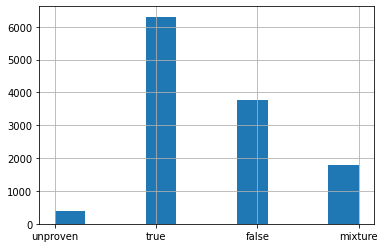

In [ ]:
df_dataset['label'].hist()

In [ ]:
df_dataset.isna().sum() # Checking that claim column does not have nan values

claim                 0
date_published     2398
explanation           0
fact_checkers         0
main_text             0
sources               1
label                 0
subjects              0
claim_id          11018
dtype: int64

In [ ]:
df_dataset.shape

(12251, 9)

In [ ]:
# Converting label column to numerical
#### true - 0
#### false - 1
#### mixture - 2
#### unproven - 3
#df_dataset['label_desc'] = df_dataset['label'] 
df_dataset['label'].replace(to_replace=['true', 'false', 'mixture', 'unproven'], value=[0, 1, 2, 3], inplace=True)

In [ ]:
# Language review to ensure that the claims are written in English ############
df_dataset['Language'] = df_dataset['claim'].apply(detect)

In [ ]:
display(df_dataset.groupby(by='Language').size()) # Claims in other languages different to English (English is the expected language according to https://huggingface.co/datasets/health_fact))

Language
af       15
ca       21
cy        1
da       12
de       26
en    12091
es        5
et        1
fr       28
id        4
it       14
lt        1
nl       13
no        5
ro        6
sl        1
sv        2
tl        3
tr        1
vi        1
dtype: int64

In [ ]:
idx_drop = df_dataset[(df_dataset['Language'] != "en")].index # Removing all claims in other language
df_dataset.drop(idx_drop, inplace = True)

In [ ]:
df_dataset.shape

(12091, 10)

In [ ]:
df_dataset.columns

Index(['claim', 'date_published', 'explanation', 'fact_checkers', 'main_text',
       'sources', 'label', 'subjects', 'claim_id', 'Language'],
      dtype='object')

In [ ]:
# Keeping important columns
df_dataset = df_dataset.loc[:, ['claim', 'label']]

In [ ]:
df_dataset.head()

,claim,label
34656,A baby died at an unnamed medical facility be...,3
3632,Bat from Shawnee County tests positive for rab...,0
29558,Germany has banned pork from school canteens b...,1
8416,Coronavirus prompts Canada to roll out safe dr...,0
7169,"Wayne National Forest plans fires for tree, wi...",0


In [ ]:
# Saving the cleaned dataset from dataframe to csv

df_dataset.to_csv(dir_dataset + "claims_dataset_cleaned.csv")

## _______________________________________________________________________________

*Points 1 and 2 can be skipped and jumping directly from 0 to 3. Connecting with cleaned dataset*






## 3. Connecting with the cleaned dataset

In [ ]:
# Reading csv dataset cleaned in steps 1 and 2

df_dataset = pd.read_csv(dir_dataset + "claims_dataset_cleaned.csv", index_col=0)

In [ ]:
display(df_dataset)

,claim,label
34656,A baby died at an unnamed medical facility be...,3
3632,Bat from Shawnee County tests positive for rab...,0
29558,Germany has banned pork from school canteens b...,1
8416,Coronavirus prompts Canada to roll out safe dr...,0
7169,"Wayne National Forest plans fires for tree, wi...",0
...,...,...
1230,Christmas miracle for Florida dog whose heart ...,0
1231,Another dolphin dies at Arizona aquatic facility.,0
1232,"What the facts say"" is ... ""the best scenario ...",1
1233,FDA advisory panel rejects J&J drug for acute ...,0


In [ ]:
# Once we have preprocessed the dataset, we split it again in train and test subsets
from sklearn.model_selection import train_test_split

X = df_dataset.claim.values
y = df_dataset.label.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7) # Split between train and validation
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=7) #Split between train and test

## 4. Text preprocessing

### Claim standarization

In order to process and classify claims, we need to bring the text into a form that is predictable and analyzable. To do so, we apply the function *claim_processing*.

In [ ]:
nltk.download('stopwords')

def claim_preprocessing(claim):
    # Lowercasing the sentence
    claim = claim.lower() 
    # Changing 't to 'not'
    claim = re.sub(r"\'t", " not", claim) 
    # Removing @name
    claim = re.sub(r'(@.*?)[\s]', ' ', claim)
    # Removing punctuations except '?'
    claim = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', claim)
    claim = re.sub(r'[^\w\s\?]', ' ', claim)
    # Removing some special characters
    claim = re.sub(r'([\;\:\|•«\n])', ' ', claim)
    # Removing stopwords except 'not' and 'can'
    claim = " ".join([word for word in claim.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    claim = re.sub(r'\s+', ' ', claim).strip()
    
    return claim

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Tokenizing

In order to use a pre-trained BERT model, the input data needs to be converted into an appropriate format in order that each sentence can be sent to the pre-trained model to obtain the corresponding embedding. 
The tokenizer object allows the conversion from character strings to tokens understood by the different models.

In order to tokenize any sentece, next steps need to be followed: 

*   **Step 1:** Add the [CLS] and [SEP] tokens: [CLS] token at the beginning, and the [SEP] token at the end of each input text.
*   **Step 2:** Pad or truncate the sentence to the maximum length allowed: for sentences that are shorter than this maximum length, we will have to add paddings (empty tokens) to the sentences to make up the length.
*   **Step 3**: Create the attention masks which explicitly differentiate real tokens from [PAD] tokens

*Extracted from Huggingface transformers documentation: https://huggingface.co/transformers/model_doc/bert.html*

In [ ]:
from transformers import BertTokenizer

# Loading the BERT tokenizer. Each model has its own tokenizer, and some tokenizing methods are different across tokenizers
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) 

# Creating a function to tokenize claims
def preprocessing_claim_for_bert(data):
    input_ids = []      # Empty lists to store outputs
    attention_masks = []

    for claim in data:
        encoded_claim = tokenizer.encode_plus(  # Encode the tokens into their corresponding IDs 
            text = claim_preprocessing(claim),  # Step 0: Preprocessing claim
            add_special_tokens=True,        # Step 1: Adding '[CLS]' and '[SEP]'
            max_length = MAX_LEN,             # Max length to truncate/pad
            pad_to_max_length = True,         # Step 2: Pad sentence to max length
            return_attention_mask=True       # Step 3: Return attention mask
            )
        
        # Adding the outputs to the lists
        input_ids.append(encoded_claim.get('input_ids'))
        attention_masks.append(encoded_claim.get('attention_mask'))

    # Converting lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks # Returning inputs_ids and attention_masks as tensors

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Concatenating claims 
all_claims = np.concatenate([df_dataset['claim'].values])

# Encode our concatenated data
encoded_claims = [tokenizer.encode(claim, add_special_tokens=True) for claim in all_claims]

# Finding the maximum length
max_len = max([len(claim) for claim in encoded_claims])
print('Max length: ', max_len)

#Specify 'MAX_LEN'
MAX_LEN = max_len

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_claim_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function 'preprocessing_claim_for_bert' on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_claim_for_bert(X_train)
val_inputs, val_masks = preprocessing_claim_for_bert(X_val)

Max length:  104
Original:   A baby died at an unnamed medical facility because its parents refused to allow a black nurse to care for the child.
Token IDs:  [101, 3336, 2351, 13294, 2966, 4322, 3008, 4188, 3499, 2304, 6821, 2729, 2775, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Converting other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# In order to fine-tune BERT, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=8)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

## 5. Building and training the model - TL from BERT Transformer

In order to complete the proposed task we will use BERT to train a text classifier. Specifically, we will take the pre-trained BERT model, add an untrained layer of neurons on the end, and train the new model for our classification task. 

Fine-tunning this modeling has several advantages comparing it to training a specific deep learning model (a CNN, BiLSTM, etc.). Among others:
- Less training time: the authors recommend only 2-4 epochs of training for fine-tuning BERT on a specific NLP task 
- Less data
- Good results

In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla K80


In [ ]:
# Create the BertClassfier class - Model for Classification Tasks
class BertClassifier(nn.Module):

    def __init__(self, freeze_bert=False): # freeze_bert (bool)'False' to fine-tune the BERT model

        super(BertClassifier, self).__init__()
        D_in = 768 # Hidden size of BERT
        H = 50 # Hidden size of the classifier
        D_out = 4 # Number of labels

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token '[CLS]' for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits # Output tensor with shape (batch_size, num_labels)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=2e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=21):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=12, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
# Training the model

set_seed(21)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=3)
train(bert_classifier, train_dataloader, val_dataloader, epochs=3, evaluation=True)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.228920   |     -      |     -     |   7.59   
   1    |   40    |   1.111457   |     -      |     -     |   6.95   
   1    |   60    |   1.050227   |     -      |     -     |   6.97   
   1    |   80    |   1.109736   |     -      |     -     |   6.95   
   1    |   100   |   1.079981   |     -      |     -     |   6.91   
   1    |   120   |   0.993034   |     -      |     -     |   6.91   
   1    |   140   |   1.035402   |     -      |     -     |   6.90   
   1    |   160   |   0.895059   |     -      |     -     |   6.93   
   1    |   180   |   1.030211   |     -      |     -     |   6.90   
   1    |   200   |   1.012641   |     -      |     -     |   6.90   
   1    |   220   |   0.965264   |     -      |     -     |   6.91   
   1    |   240   |   0.920818   |     -      |     -     |   6.90   


## 6. Performance evaluation

### Setup test dataset for BERT


In [ ]:
# Running 'preprocessing_claim_for_bert' on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_claim_for_bert(X_test)

test_labels = torch.tensor(y_test)

# Creating the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


### Compute predicted probabilities on the test set

In [ ]:
def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during the test time.
    model.eval()
    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs # Output tensor with shape (batch_size, num_labels)

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

In [ ]:
def evaluate_classifier(probs, y_true):
    preds = probs[:, 1]
       
    # Get accuracy over the test set
    y_pred = np.argmax(probs, axis=1, out=None)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Plot a multilabel confusion matrix
    fig = plt.figure()
    skplt.metrics.plot_confusion_matrix(y_true, y_pred, figsize=(12,15))
    fig.suptitle('Confusion Matrix', fontsize=16)

    # Get Classification Report
    print(pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)))

Accuracy: 61.58%
                     0           1  ...    macro avg  weighted avg
precision     0.761170    0.513948  ...     0.390348      0.587097
recall        0.760552    0.649932  ...     0.403315      0.615798
f1-score      0.760861    0.573996  ...     0.393064      0.597965
support    1232.000000  737.000000  ...  2418.000000   2418.000000

[4 rows x 7 columns]


<Figure size 432x288 with 0 Axes>

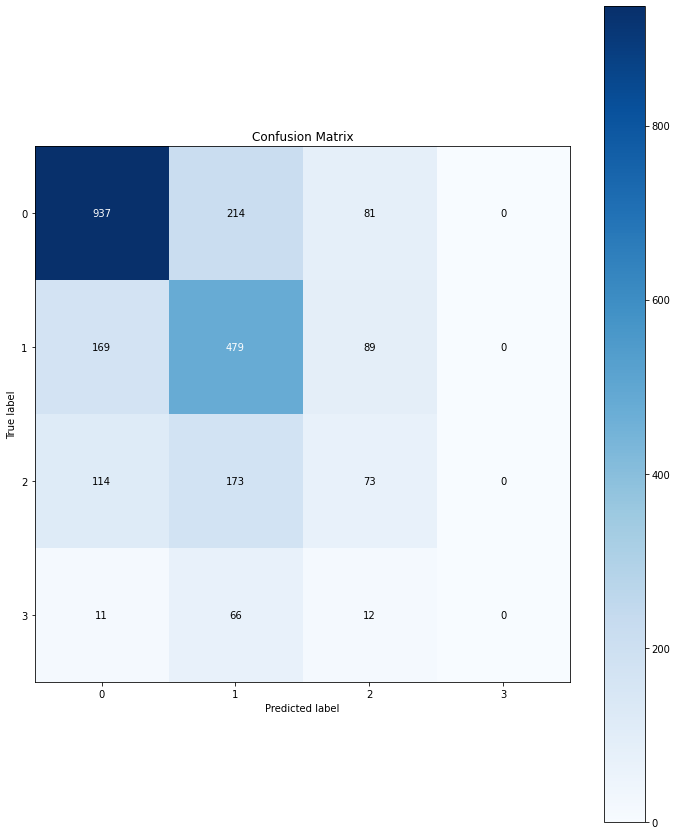

In [ ]:
# Evaluate the Bert classifier
evaluate_classifier(probs, test_labels)

When we use the trained model to predict the veracity on the unseen test dataset, the confusion matrix clearly shows how the model overfits to the majority True and False classes.

Model performance can be increased with using additional techniques as Data Augmentation given that the input dataset is clearly bias including as the vast majority claims categorized as True and False.

## Trying out the model with a new health claim

Once we have a final model we apply it to a different health claim from a different source: 

**External claim:** *Receiving many vaccines for different diseases at the same time increases the risk of undesirable effects and can overload the immune system*

**Label:** False. 

Rationale found in http://proyectoavatar.enfermeriacomunitaria.org/vacunas/mitos-y-realidades (13rd Myth)

In [ ]:
external_claim = "Receiving many vaccines for different diseases at the same time increases the risk of undesirable effects and can overload the immune system"

In [ ]:
# Running 'preprocessing_claim_for_bert' on the external claim
print('Tokenizing data...')
b_input_ids, b_attn_mask = preprocessing_claim_for_bert(external_claim)

print('Applying BERT tokenizer prediction..')
with torch.no_grad():
    logits = bert_classifier(b_input_ids.to(device), b_attn_mask.to(device))
    probs = F.softmax(logits, dim=1).cpu().numpy()
    y_pred = np.unique(np.argmax(probs, axis=1, out=None))

Tokenizing data...
Applying BERT tokenizer prediction..


In [ ]:
def veracity_prediction(y_pred):
  if str(y_pred[0]) == '0':
    return 'True'
  if str(y_pred[0]) == '1':
    return 'False'
  if str(y_pred[0]) == '2':
    return 'Mixture'
  if str(y_pred[0]) == '3':
    return 'Unproven'

print('Veracity prediction: ' + veracity_prediction(y_pred))

Veracity prediction: True
